In [21]:
import xml.etree.ElementTree as elemT
import fr_core_news_md
import re
import pandas as pd
import numpy as np
import seaborn as sb
import nltk
from nltk.corpus import stopwords as sw
from nltk.tokenize import TreebankWordTokenizer as twt
import spacy
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
from sklearn.decomposition import LatentDirichletAllocation as LDA
import seaborn as sns

In [12]:
!python -m spacy download fr_core_news_md

  Created wheel for fr-core-news-md: filename=fr_core_news_md-2.3.0-py3-none-any.whl size=46100670 sha256=ad951718b73a9941e3346de81adf6649cd0543b761339f9d50e5d10fb72ec3fd
  Stored in directory: C:\Users\33652\AppData\Local\Temp\pip-ephem-wheel-cache-yjf0wkii\wheels\62\a5\93\9c82d8ae84430ed80720262c11726d046d3444af301b7d2895
Successfully built fr-core-news-md
[+] Download and installation successful
You can now load the model via spacy.load('fr_core_news_md')


You should consider upgrading via the 'C:\Users\33652\AppData\Local\Programs\Python\Python37\python.exe -m pip install --upgrade pip' command.


In [16]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\33652\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

### Data Retrieval

In [2]:
def CreateDataFrame():
    tree = elemT.parse("C:/Users/33652/Desktop/ESILV/A5/ADV machine learning/Project_2/corpus-taln/corpus-taln/2/corpus_taln_v1.tei.xml")
    root = tree.getroot()

    allText = []
    allText_en = []

    for child in root:
        corpus = ""
        title = ""
        date = ""
        abstract = ""
        keyword = ""

# Occupons nous des textes en français car ils composent la majorité du corpus (environ 1500 sur 1600)
        if child.get("{http://www.w3.org/XML/1998/namespace}lang") == "fr":
            title = GetRidOfLineBreak(str(child[0][0][0][0].text).lower())
            date = GetRidOfLineBreak(str(child[0][0][1][2].text).lower())
            abstract = GetRidOfLineBreak(str(child[1][0][0][0].text).lower())
            keyword = GetRidOfLineBreak(str(child[1][0][2][0].text).lower())
            for i in range(len(child[1][1])):
                for j in range(len(child[1][1][i])):
                    if len(child[1][1][i]) > 1:
                        for k in range(len(child[1][1][i][j])):
                            tempTxt = GetRidOfLineBreak(str(child[1][1][i][j][k].text).lower() + " ")
                            corpus = corpus + tempTxt
                    else:
                        tempTxt = GetRidOfLineBreak(str(child[1][1][i][j].text).lower() + " ")
                        corpus = corpus + tempTxt
            allText.append([title, date, abstract, corpus, keyword])
            
    df = pd.DataFrame(allText,columns=["Title", "Date", "Abstract", "Corpus", "Keyword"])
    return df

def GetRidOfLineBreak(string):
    regex = re.compile(r'[\n\r\t]')
    return regex.sub(" ", string)




In [3]:
df = CreateDataFrame()

### Creating Preprocessing functions

In [4]:
def GetRidOfApostrophe(df, column):
    replacements = (("d\'", "de "), ("qu\'", "que "), ("l\'", "le "), ("j\'", "je "), ("c\'", "ce "), ("s\'", "se "), ("n\'", "ne "), ("m\'", "me "), ("t\'", "te "))
    for replacement in replacements:
        df[column] = df[column].str.replace(*replacement)

def GetRidOfSpecialCharacter(df, column):
    df[column] = df[column].str.replace('[\-\[\]+;\'!\^:/,"#&@\(\)\$\?%\_\*«»]|[A-Z]\.|None|', "")

def GetRidOfAccent(df, column):
    replacements = (("[éèêë]", "e"), ("[àâ]", "a"), ("[ùûü]", "u"), ("[ïî]", "i"), ("[ö]", "o"), ("[ç]", "c"))
    for replacement in replacements:
        df[column] = df[column].str.replace(*replacement)

In [5]:
def Preprocessing(df):
    columns = ["Title", "Date", "Abstract", "Corpus", "Keyword"]
    for column in columns:
        GetRidOfApostrophe(df, column)
        GetRidOfSpecialCharacter(df, column)
        GetRidOfAccent(df, column)
def UseStopWords(df):
    stopWords = sw.words("french")
    columns = ["Title", "Abstract", "Corpus", "Keyword"]

    for column in columns:
        df[column] = df[column].apply(lambda i : ' '.join([word for word in i.split() if word not in stopWords]))


In [14]:
def lemmatizer(df):
    nlp = fr_core_news_md.load()
    columns = ["Title", "Abstract", "Corpus"]

    for index, row in df.iterrows():
        for column in columns:
            doc = nlp(row[column])
            result = ""
            count = 0
            for token in doc:
              result = result + token.lemma_
              count = count + 1
              if count < len(doc)-1:
                result = result + " "
            row[column] = result

### Preprocessing Text

In [17]:
lemmatizer(df)
Preprocessing(df)
UseStopWords(df)

<Figure size 432x288 with 0 Axes>

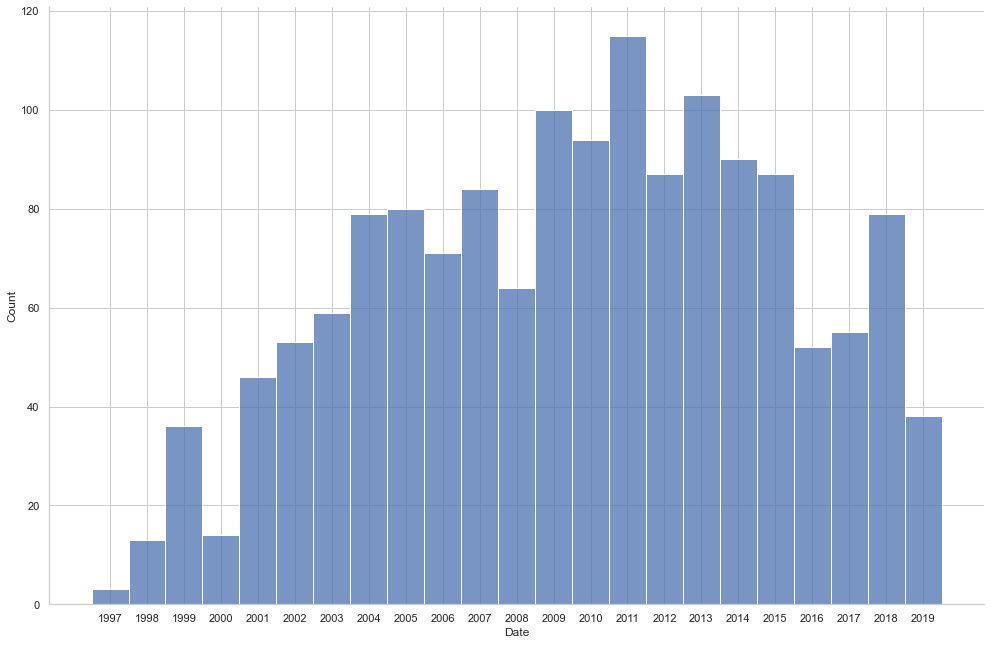

In [51]:
import matplotlib.pyplot as plt
fig = plt.gcf()
sns.set(style="whitegrid")
g = sns.displot(df, x="Date",binwidth=5)
g.fig.set_figwidth(16)
g.fig.set_figheight(10)

In [86]:
title_len = df.Title.values
len_title = []
for item in title_len:
    len_title = np.append(len_title,[len(item)], axis= 0)
df['len_title'] = len_title

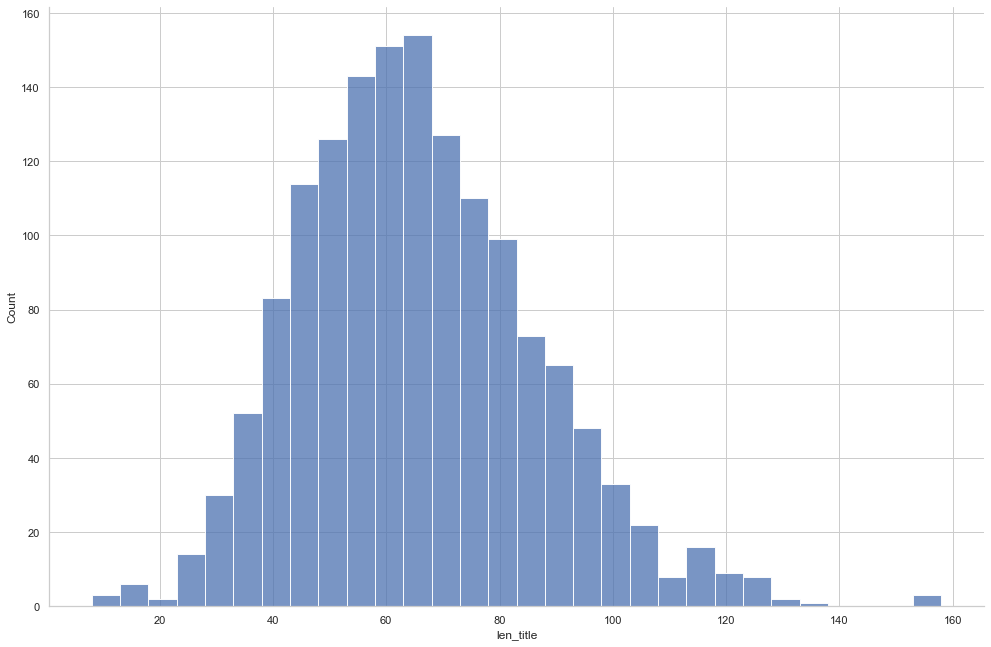

In [97]:
g = sns.displot(df, x="len_title",binwidth=5)
g.fig.set_figwidth(16)
g.fig.set_figheight(10)

In [ ]:
# Analyser la distribution des années sur le dataframe
# Créer une fonction qui permettrait de balance les données en année si c'est compliqué puis diviser en 80/10/10
# Quand on aura notre premier moèdle, ce serait d'analyser le pourcentage de confidence (60% de proba pour le choix d'un article,
#le dire et montrer ce qu'on peut faire pour improve THE MODEL)
# Quelle année est compliqué à compute, pourquoi ? analyse des mots qui permettent de décider de l'année (Feature Importance)
# Quels mots sont compliqués, ont rendu la tâche de régression compliquée. 
# Ne pas considérer le problème comme une classification